In [9]:
import os
import tarfile

def recursive_files(dir_name='.', ignore=None):
    for dir_name,subdirs,files in os.walk(dir_name):
        if ignore and os.path.basename(dir_name) in ignore: 
            continue

        for file_name in files:
            if ignore and file_name in ignore:
                continue

            yield os.path.join(dir_name, file_name)

def make_tar_file(dir_name='.', tar_file_name='tarfile.tar', ignore=None):
    tar = tarfile.open(tar_file_name, 'w')

    for file_name in recursive_files(dir_name, ignore):
        tar.add(file_name)

    tar.close()


dir_name = '.'
tar_file_name = 'MNIST.tar'
make_tar_file(dir_name, tar_file_name, ignore)

In [1]:
# Basic setup & Import related modules 
import tensorflow as tf 
import numpy as np
import keras
import matplotlib.pyplot as plt
import random, math

plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# storage
import os
from cv2 import imwrite
from datetime import datetime

save_dir = './seeds/'

if os.path.exists(save_dir):
    for i in os.listdir(save_dir):
        path_file = os.path.join(save_dir, i)
        if os.path.isfile(path_file):
            os.remove(path_file)

# if storage dir not exists
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

import utils, network, source_mut_operators 
utils = utils.GeneralUtils()
network = network.CNNNetwork() #
source_mut_opts = source_mut_operators.SourceMutationOperators()
 
(train_datas, train_labels), (test_datas, test_labels) = network.load_and_preprocess_data() # randomly pick data and do normalization：[0,255] -> [0,1] 

print('train_datas shape:', train_datas.shape)
print('test_datas shape:', test_datas.shape)
print('train_labels shape:', train_labels.shape)
print('test_labels shape:', test_labels.shape)

mutation_ratios = [i*0.05 + 0.05 for i in range(5,8)]

mutant_accuracy_control_threshold = [0.92 for i in mutation_ratios if i < 0.5] + [0.88 for i in mutation_ratios if i >= 0.5]

# initialize as an empty numpy array 
gen_test_cases = np.zeros(train_datas.shape)
gen_test_cases = np.delete(gen_test_cases, slice(0, gen_test_cases.shape[0]), axis=0) # remove the all the lines, only keeps the shape (0, 32, 32, 1)
total_test_cases_num = 0
difference_indexes = [] # a set for all differences among different operators 
difference_scores = []
counter = 0

Using TensorFlow backend.


Shuffle train_datas and test_datas.

Extract: training 5000 + testing 1000
train_datas shape: (5000, 28, 28, 1)
test_datas shape: (1000, 28, 28, 1)
train_labels shape: (5000, 10)
test_labels shape: (1000, 10)


In [14]:
# load model
# normal FC model, not CNN 
# model = network.create_normal_FC_model()
from keras.layers import Input
from Model1 import Model1
from Model2 import Model2
from Model3 import Model3
import sys

input_tensor = Input(shape=(28,28,1))
# create_CNN_model_1(): LeNet 5
# way1:
# model = network.create_CNN_model_1()

# way2 : don't work
# model = network.load_model('Model3.h5')

# way3:

# model_name = sys.argv[6]
# if model_name == 'model1':
#     model = Model1(input_tensor=input_tensor)
    
# elif model_name == 'model2':
model = Model2(input_tensor=input_tensor)
    
# elif model_name == 'model3':
#     model = Model3(input_tensor=input_tensor)
    
# else:
#     print('please specify model name')
#     os._exit(0)



in LeNet-4 input_tensor =  Tensor("input_8:0", shape=(?, 28, 28, 1), dtype=float32)
Model2: LeNet-4 loaded


In [6]:
# initialize as an empty numpy array
def initialize_before_each_mutation():
    global gen_test_cases 
    gen_test_cases = np.delete(gen_test_cases, slice(0, gen_test_cases.shape[0]), axis=0) # remove the all the lines, only keeps the shape (0, 28, 28, 1)
    global difference_indexes 
    difference_indexes = [] # a set for all differences among different operators
    global difference_scores
    difference_scores = []
    global counter 
    counter = 0
    
def deprocess_image(x):
    # de-normalization: [0,1] -> [0,255]     
    x *= 255
    if x.shape == (32,32,1):
        return x.squeeze()[0+2:31-1,0+2:31-1] #  indexing:[2:30], np.squeeze will remove single dimension: (32,32,1)-> (28,28)
    # (784,0)
    elif x.shape == (28,28,1):
        return x.reshape(28,28) #  for one test_case,original shape (784,)
    else:
        print('sth wrong...')
        return

def np_unique_without_sorting(a, axis):
    _, idx = np.unique(a, axis, return_index=True)
    return a[np.sort(idx)]

def remove_duplicate_without_sorting(seq): 
   # order preserving
   noDupes = []
   [noDupes.append(i) for i in seq if not noDupes.count(i)]
   return noDupes

# store test cases in to local folder
# difficult: correspondences exist between test cases and their respecitve real labels
def store_test_cases(mutation_name, difference_indexes, right_labels, gen_test_cases):
    difference_indexes = remove_duplicate_without_sorting(difference_indexes)
    for index, test_case in enumerate(gen_test_cases):
        imwrite('%s%d_%d.png' % (save_dir + mutation_name, index + 1, right_labels[difference_indexes[index]]), deprocess_image(test_case))
        

def run_operator(mutation_ratios, operator_name, model, train_dataset, test_datas, test_labels,
                 AFRs_mutated_layer_indices = None,
                 GF_prob_distribution = 'normal', GF_layers_indices=None):
    # initialize as an empty numpy array
    initialize_before_each_mutation()
    
    global gen_test_cases     
    global difference_indexes     
    global difference_scores    
    global counter 
    global total_test_cases_num
    right_labels = np.argmax(test_labels, axis=1) # right answers
    
    print("\n-----------------------------" + operator_name + " mutation operator-----------------------------")
    for mutation_ratio in mutation_ratios:
        if operator_name == 'DR':
            (mutated_datas, mutated_labels), mutated_model = source_mut_opts.DR_mut(train_dataset, model, mutation_ratio)
        elif operator_name == 'LE':
            lower_bound = 0
            upper_bound = 9
            (mutated_datas, mutated_labels), mutated_model = source_mut_opts.LE_mut(train_dataset, model, lower_bound, upper_bound, mutation_ratio)
        elif operator_name == 'DM':
            (mutated_datas, mutated_labels), mutated_model = source_mut_opts.DM_mut(train_dataset, model, mutation_ratio)
        elif operator_name == 'DF':
            (mutated_datas, mutated_labels), mutated_model = source_mut_opts.DF_mut(train_dataset, model, mutation_ratio)
        elif operator_name == 'NP':
            STD = 5
            (mutated_datas, mutated_labels), mutated_model = source_mut_opts.NP_mut(train_dataset, model, mutation_ratio, STD=STD)
#         elif operator_name == 'LR':
#             mutated_layer_indices = None
#             (mutated_datas, mutated_labels), mutated_model = source_mut_opts.LR_mut(train_dataset, model, mutated_layer_indices=mutated_layer_indices)
#         elif operator_name == 'LAs':
#             mutated_layer_indices = None
#             (mutated_datas, mutated_labels), mutated_model = source_mut_opts.LAs_mut(train_dataset, model, mutated_layer_indices=mutated_layer_indices)
        elif operator_name == 'AFRs':
            mutated_layer_indices = AFRs_mutated_layer_indices
            (mutated_datas, mutated_labels), mutated_model = source_mut_opts.AFRs_mut(train_dataset, model, mutated_layer_indices=mutated_layer_indices)
        else:
            print("Input is not a valid operator mode")
            return
        
        # compile model        
        model = network.compile_model(model)
        mutated_model = network.compile_model(mutated_model)
        
        # train model
        trained_model = network.train_model(model, train_datas, train_labels)
        trained_mutated_model = network.train_model(mutated_model, mutated_datas, mutated_labels)

        # quality control of mutant model
        mutant_loss, mutant_acc = trained_mutated_model.evaluate(test_datas, test_labels, verbose=False)
        if mutant_acc < mutant_accuracy_control_threshold[counter]:
          counter += 1
          difference_scores.append(0)
          print("{0}th mutant behaves badly, with acc {1:.2%} and mutation ratio {2:.3f}, will be dropped out\n".format(counter, mutant_acc, mutation_ratio))
          continue
        print("{0}th mutant passes the quality test, with acc {1:.2%} and mutation ratio {2:.3f}".format(counter + 1, mutant_acc, mutation_ratio))

        # test the mutated model         
        mutant_predi_labels = np.argmax(trained_mutated_model.predict(test_datas), axis = 1)
        
        # compare the test reasults with correct result 
        #  np.nonzero(right_labels-mutant_predi_labels) is a tuple with only one element: the [0],a numpy array
        difference_indexes = difference_indexes + list(np.nonzero(right_labels-mutant_predi_labels)[0]) 
        difference_score = len(difference_indexes) / right_labels.size 
        difference_scores.append(difference_score) 

        
        print(" difference ratio: %.3f  with mutation ratio: %.2f" % (difference_score, mutation_ratio))
        prev_gen_test_cases = gen_test_cases
        additional_test_cases = test_datas[np.nonzero(right_labels-mutant_predi_labels)[0]]
        concat_test_cases = np.append(gen_test_cases, additional_test_cases,axis = 0)      
        _, idx = np.unique(concat_test_cases, axis = 0, return_index=True)
        gen_test_cases = concat_test_cases[np.sort(idx)]

        counter += 1
        print(" new test cases + %d\n" % (gen_test_cases.shape[0] - prev_gen_test_cases.shape[0]))
        # end of loop
        
    plt.title(operator_name + ' mutation deferences')
    plt.axis([mutation_ratios[0], mutation_ratios[-1], 0, 0.1])
    plt.plot(mutation_ratios, difference_scores)
    plt.xlabel('Mutation ratio')
    plt.ylabel('Differences')
    plt.show()

    # save the test cases causing differences    
    store_test_cases(operator_name, difference_indexes, right_labels, gen_test_cases)
    total_test_cases_num += gen_test_cases.shape[0]
    print("now %d test cases are saved\n" % total_test_cases_num)   
        


-----------------------------DR mutation operator-----------------------------
ramdomly repeat 1500 training datasets, totally 6500
1th mutant passes the quality test, with acc 98.30% and mutation ratio 0.300
 difference ratio: 0.017  with mutation ratio: 0.30
 new test cases + 17

ramdomly repeat 1750 training datasets, totally 6750
2th mutant passes the quality test, with acc 98.40% and mutation ratio 0.350
 difference ratio: 0.033  with mutation ratio: 0.35
 new test cases + 3

ramdomly repeat 2000 training datasets, totally 7000
3th mutant passes the quality test, with acc 98.30% and mutation ratio 0.400
 difference ratio: 0.050  with mutation ratio: 0.40
 new test cases + 5



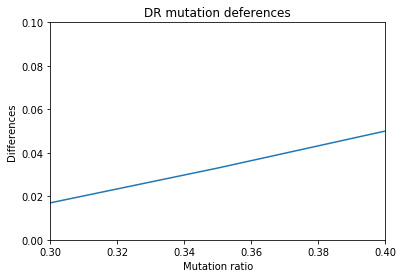

now 25 test cases are saved



In [15]:
# 1. DR (Data Repetition)
run_operator(mutation_ratios, "DR", model, (train_datas, train_labels), test_datas, test_labels)

In [16]:
# 2. LE (Label Error)
run_operator(mutation_ratios, "LE", model, (train_datas, train_labels), test_datas, test_labels) 


-----------------------------LE mutation operator-----------------------------
ramdomly falsify 1500 training datasets' labels: now 3500 correct labels
1th mutant behaves badly, with acc 79.40% and mutation ratio 0.300, will be dropped out

ramdomly falsify 1750 training datasets' labels: now 3250 correct labels
2th mutant behaves badly, with acc 70.90% and mutation ratio 0.350, will be dropped out

ramdomly falsify 2000 training datasets' labels: now 3000 correct labels


KeyboardInterrupt: 

In [ ]:
# 3. DM (Data Missing)
run_operator(mutation_ratios, "DM", model, (train_datas, train_labels), test_datas, test_labels) 

In [ ]:
# 4. DF (Data Shuffle)
run_operator(mutation_ratios, "DF", model, (train_datas, train_labels), test_datas, test_labels) 

In [ ]:
# 5. NP - Noise Perturb, STD is 10 by default, can be modified in run_operator
run_operator(mutation_ratios, "NP", model, (train_datas, train_labels), test_datas, test_labels) 

In [ ]:
# # 6.LR - Layer Removal
# run_operator(mutation_ratios, "LR", model, (train_datas, train_labels), test_datas, test_labels) 

In [ ]:
# # 7. LAs - Layer Addition
# run_operator(mutation_ratios, "LAs", model, (train_datas, train_labels), test_datas, test_labels) 

In [ ]:
# 8. AFRs - Activation Function Removal
run_operator(mutation_ratios, "AFRs", model, (train_datas, train_labels), test_datas, test_labels) 